# Moving Square Video Prediction Problem

In [10]:
from numpy import zeros
from random import randint, random
import matplotlib.pyplot as plt
%matplotlib inline

# generate the next frame in the sequence
def next_frame(last_step, last_frame, column):
    lower = max(0, last_step - 1)
    upper = min(last_frame.shape[0] - 1, last_step + 1)
    step = randint(lower, upper)
    frame = last_frame.copy()
    frame[step, column] = 1
    return frame, step

# generate a sequence of frames of a dot moving across an image
def build_frames(size):
    frames = list()
    frame = zeros((size, size))
    step = randint(0, size - 1)
    # 左に行くか、右に行くかを決める
    right = 1 if random() < 0.5 else 0
    col = 0 if right else size - 1
    frame[step, col] = 1
    frames.append(frame)
    # create all remaining frames
    for i in range(1, size):
        col = i if right else size - 1 - i
        frame, step = next_frame(step, frame, col)
        frames.append(frame)
    return frames, right

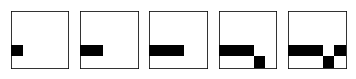

In [15]:
# generate sequence of frames
size = 5
frames, right = build_frames(size)
plt.figure()
for i in range(size):
    plt.subplot(1, size, i + 1)
    plt.imshow(frames[i], cmap='Greys')
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [16]:
import numpy as np
# generate multiple sequences of frames and reshape for network input
def generate_examples(size, n_patterns):
    X, y = list(), list()
    for _ in range(n_patterns):
        frames, right = build_frames(size)
        X.append(frames)
        y.append(right)
    # (samples, timesteps, width, height, channels)
    X = np.array(X).reshape(n_patterns, size, size, size, 1)
    y = np.array(y).reshape(n_patterns, 1)
    return X, y

In [17]:
size = 50

In [21]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, LSTM, TimeDistributed
# define the model
model = Sequential()
model.add(TimeDistributed(Conv2D(2, (2, 2), activation='relu'),
                          input_shape=(None, size, size, 1)))  # (timesteps, width, height, channels)
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_6 (TimeDist (None, None, 49, 49, 2)   10        
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 24, 24, 2)   0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 1152)        0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                240600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 240,661
Trainable params: 240,661
Non-trainable params: 0
_________________________________________________________________
None


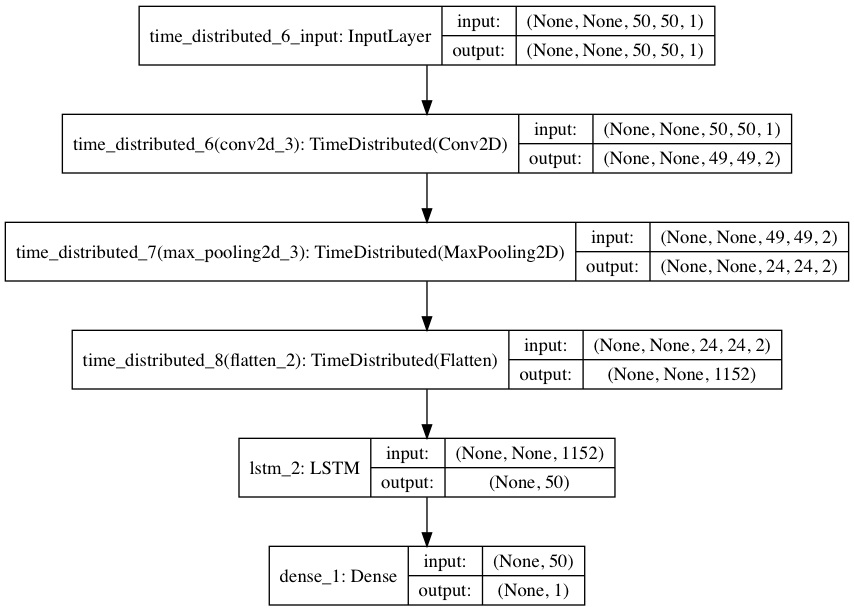

In [22]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image('model.png')

In [23]:
# fit model
X, y = generate_examples(size, 5000)
model.fit(X, y, batch_size=32, epochs=1)

Epoch 1/1
5000/5000 [==============================] - 101s - loss: 0.1404 - acc: 0.9356   


In [26]:
# evaluate the model
X, y = generate_examples(size, 100)
loss, acc = model.evaluate(X, y, verbose=0)
print('loss: %f, acc: %f' % (loss, acc * 100))

loss: 0.002858, acc: 100.000000


In [27]:
# prediction on new data
X, y = generate_examples(size, 1)
yhat = model.predict_classes(X, verbose=0)
expected = 'Right' if y[0] == 1 else 'Left'
predicted = 'Right' if yhat[0] == 1 else 'Left'
print('Expected: %s, Predicted: %s' % (expected, predicted))

Expected: Left, Predicted: Left
